In [5]:
#Run this notebook in the root directory of the project
%cd ../../../

/data/main/2024/GridCellsCond


## Path integration result

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sim_utils as s_utils
import analysis_utils as a_utils
from network_configs.instrumentations.trajectory1D import Trajectory1D
from scipy import stats

In [3]:
def circular_error(var1,var2):

    """Calculate the circular error between two angles.

    Parameters:
        var1 (float or array-like): The first angle in radians.
        var2 (float or array-like): The second angle in radians.
    Returns:
        numpy.ndarray: The minimum absolute difference between the angles
    """
    circum = 2*np.pi
    return np.abs(np.min(np.vstack((np.abs(var1-var2),circum-np.abs(var1-var2))),axis=0))

In [8]:
sim_id='VALD-PI-TRAJ-S-m-1a'
params=s_utils.load_sim_params(sim_id)["0"]
traj = Trajectory1D(params,save_mem=False)
n_trials=10
decoded_postions = np.zeros((n_trials,int(params["sim_dur"]-traj.init_allothetic_dur)))
sim_num=0
for tr in range(n_trials):
    print(tr,end=" ")
    stell_spks,_ = s_utils.load_spikes(sim_id,sim_num=sim_num)
    decoded_postions[tr,:] = a_utils.decode_pos(stell_spks,params,win_size=40,t_start=int(traj.init_allothetic_dur))
    sim_num+=1
decoded_position_avg=stats.circmean(decoded_postions,axis=0)
std=stats.circstd(decoded_postions,axis=0)
t_ms= np.arange(traj.init_allothetic_dur,params['sim_dur'])
t_ms_idx=(t_ms/0.025).astype('int')
positions_input_ms=traj.pos_input[t_ms_idx]
velocity_input_ms=traj.vel_input[t_ms_idx]
t_s= np.linspace(traj.init_allothetic_dur/1000,(params['sim_dur']/1000),len(decoded_postions[0]))


0 1 2 3 4 5 6 7 8 9 

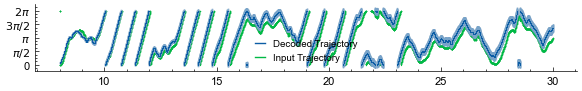

In [5]:
#Plot a scatter plot of the decoded position and the input position
from matplotlib.lines import Line2D
t_s= np.linspace(traj.init_allothetic_dur/1000,(params['sim_dur']/1000),len(decoded_postions[0]))
plt.style.use("analysis/config/paper.mplstyle")
fig,ax=plt.subplots(1,1,figsize=(7,0.87))
ax.errorbar(x=t_s,y=decoded_position_avg,yerr=std,ecolor=(119/255, 163/255, 201/255,0.25),fmt="none")
l1=ax.scatter(t_s,decoded_position_avg,label=f'Decoded Trajectory',zorder=2,s=0.5,linewidth=0)
ax.scatter(t_s,positions_input_ms,label='Input Trajectory',s=0.75,linewidth=0,c="#00B945")
ax.set_yticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
ax.set_yticklabels(["0","$\\pi /2$","$\\pi$","$3\\pi /2$","$2 \\pi$"])
legend_elements = [Line2D([0], [0], color='#0C5DA5', lw=1, label='Decoded Trajectory'),
                   Line2D([0], [0], color='#00B945', lw=1, label='Input Trajectory')]
leg=ax.legend(handles=legend_elements, loc='best',handlelength=1,fontsize=7)
plt.show()

In [24]:

import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.style.use("analysis/config/paper.mplstyle")

t_ms= np.arange(traj.init_allothetic_dur,params['sim_dur'])
# t_ms= np.arange(0,params['sim_dur'])
t_ms_idx=(t_ms/0.025).astype('int')
positions_input_ms=traj.pos_input[t_ms_idx]
velocity_input_ms=traj.vel_input[t_ms_idx]
stell_spikes_l,_=s_utils.load_spikes(sim_id)
t_s= np.linspace(traj.init_allothetic_dur/1000,(params['sim_dur']/1000),len(decoded_postions[0]))

fig,ax=plt.subplots(1,1,figsize=(24,4))

line, caps, verts =  ax.errorbar(x=t_s[0],y=decoded_position_avg[0],yerr=std[0],ecolor=(119/255, 163/255, 201/255,0.25),fmt="none")
decoded_plot=ax.scatter(t_s[0],decoded_position_avg[0],label=f'Decoded Trajectory',zorder=2,s=2)
input_plot=ax.scatter(t_s[0],positions_input_ms[0],label='Input Trajectory',c="#00B945",s=2)
ax.set_yticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
ax.set_yticklabels(["0","$\pi /2$","$\pi$","$3\pi /2$","$2 \pi$"])
ax.set_xticks(t_s[2000::4999])
# ax.set_yticklabels(["0","$\pi /2$","$\pi$","$3\pi /2$","$2 \pi$"])
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(markerscale=8,fontsize=20,loc="lower right")
# fig.tight_layout()

def update(frame):
    # for each frame, update the data stored on each artist.
    t_ = t_s[:frame]
    decoded_ = decoded_position_avg[:frame]
    input_ = positions_input_ms[:frame]
    err_ = std[:frame]
    
    # update the scatter plot:
    decoded_data = np.stack([t_, decoded_]).T
    decoded_plot.set_offsets(decoded_data)
    
    input_data = np.stack([t_, input_]).T
    input_plot.set_offsets(input_data)

    if frame==plot_frames[-1]:
        error_bar=ax.errorbar(x=t_s,y=decoded_position_avg,yerr=std,ecolor=cm.Spectral(0.85),fmt="none",zorder=0)
        # plt.pause(10)
        
    # line.set_ydata(err_)  # update the data
    # verts[0].set_ydata(std[0])
    # caps[1].set_ydata(err_ + std[frame])
    
    # caps.set_ydata(err_ + std[frame])
    
    # update the line plot:
    # decoded_plot.set_xdata(t_)
    # decoded_plot.set_ydata(decoded_)
    # input_plot.set_ydata(input_)
    return (decoded_plot,input_plot)


# ani = animation.FuncAnimation(fig=fig, func=update, frames=np.arange(0,len(t_s),100), interval=1)
fps = 30 #higher fps higher temporal resolution (longer encoding time, displays might not support)
total_samples = int(fps*(len(t_s)/1000))
plot_frames =np.linspace(0,len(t_s)-1,total_samples,dtype='int')
anim = animation.FuncAnimation(fig, update,frames = plot_frames, interval =1, blit = True)
writer = animation.FFMpegWriter(fps=fps,bitrate=4500) #bitrate: quality vs file_size
anim.save(f'data/{params['sim_id']}/stell_{params['sim_id']}.mp4', writer=writer)

<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2216300/604563419.py:19: SyntaxWarning: invalid escape sequence '\p'
  ax.set_yticklabels(["0","$\pi /2$","$\pi$","$3\pi /2$","$2 \pi$"])
/tmp/ipykernel_2216300/604563419.py:19: SyntaxWarning: invalid escape sequence '\p'
  ax.set_yticklabels(["0","$\pi /2$","$\pi$","$3\pi /2$","$2 \pi$"])
/tmp/ipykernel_2216300/604563419.py:19: SyntaxWarning: invalid escape sequence '\p'
  ax.set_yticklabels(["0","$\pi /2$","$\pi$","$3\pi /2$","$2 \pi$"])
/tmp/ipykernel_2216300/604563419.py:19: SyntaxWarning: invalid escape sequence '\p'
  ax.set_yticklabels(["0","$\pi /2$","$\pi$","$3\